In [18]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 12, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

High         Low        Open       Close       Volume  \
Date                                                                      
2020-12-07  124.570000  122.250000  122.309998  123.750000   86712000.0   
2020-12-08  124.980003  123.089996  124.370003  124.379997   82225500.0   
2020-12-09  125.949997  121.000000  124.529999  121.779999  115089200.0   
2020-12-10  123.870003  120.150002  120.500000  123.239998   81312200.0   
2020-12-11  122.760002  120.550003  122.430000  122.410004   86939800.0   

             Adj Close  
Date                    
2020-12-07  123.750000  
2020-12-08  124.379997  
2020-12-09  121.779999  
2020-12-10  123.239998  
2020-12-11  122.410004

In [19]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

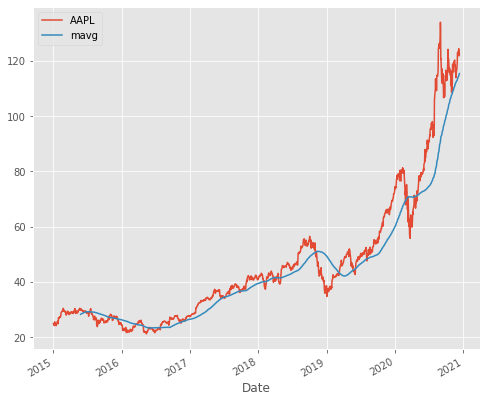

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend();

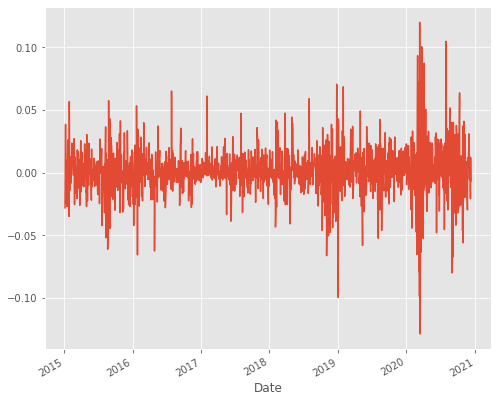

In [21]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return');

In [22]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [23]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

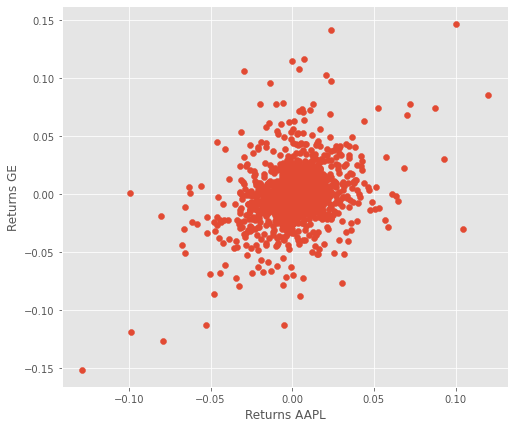

In [24]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE');

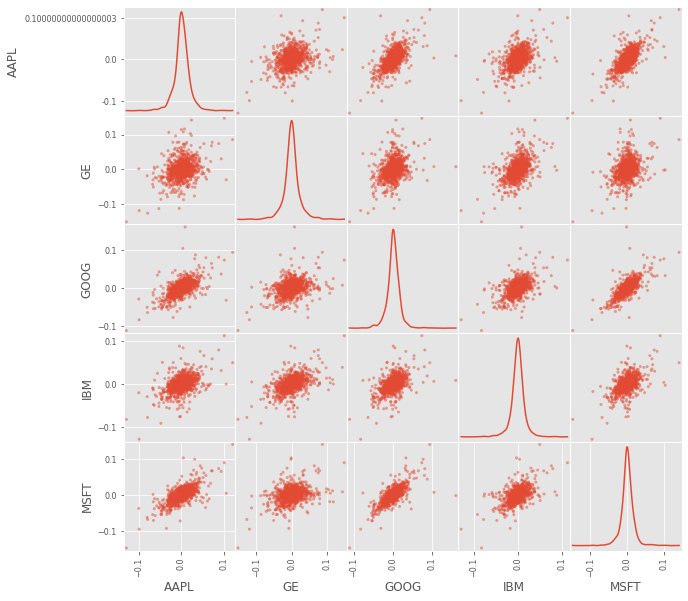

In [25]:
from pandas.plotting import scatter_matrix

scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

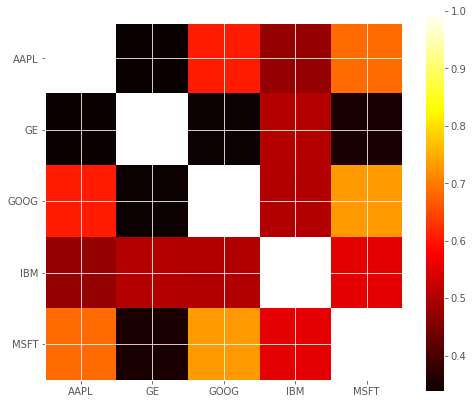

In [26]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

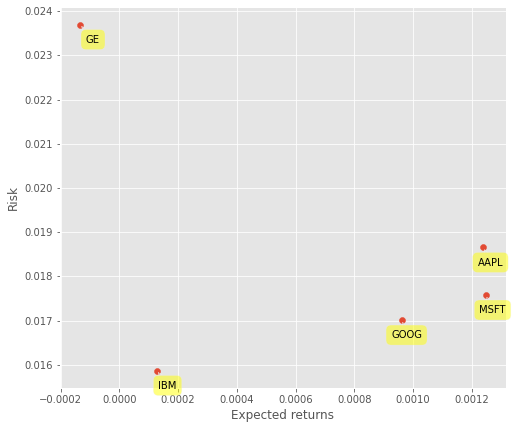

In [27]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# Predicting Stocks Price
## Feature Engineering
* We will use these three machine learning models to predict our stocks: Simple Linear Analysis, Quadratic Discriminant Analysis (QDA), and K Nearest Neighbor (KNN). But first, let us engineer some features: High Low Percentage and Percentage Change.

In [30]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

# Pre-processing & Cross Validation
We will clean up and process the data using the following steps before putting them into the prediction models:
Drop missing value
Separating the label here, we want to predict the AdjClose
Scale the X so that everyone can have the same distribution for linear regression
Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
Separate label and identify it as y
Separation of training and testing of model by cross validation train test split

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline


In [39]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = sklearn.preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [44]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())])

In [45]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [68]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print(
    ('The linear regression confidence is ', confidencereg),
    ('The quadratic regression 2 confidence is ', confidencepoly2),
    ('The quadratic regression 3 confidence is ', confidencepoly3),
    ('The knn regression confidence is ', confidenceknn)
)

('The linear regression confidence is ', 0.9730486840871587) ('The quadratic regression 2 confidence is ', 0.9741238364375143) ('The quadratic regression 3 confidence is ', 0.9689830487317881) ('The knn regression confidence is ', 0.9501070991542385)


In [73]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
dfreg['Forecast']
# #result
# (array([ 115.44941187,  115.20206522,  116.78688393,  116.70244946,
#         116.58503739,  115.98769407,  116.54315699,  117.40012338,
#         117.21473053,  116.57244657,  116.048717  ,  116.26444966,
#         115.78374093,  116.50647805,  117.92064806,  118.75581186,
#         118.82688731,  119.51873699]), 0.96234891774075604, 18)


Date
2015-01-02   NaN
2015-01-05   NaN
2015-01-06   NaN
2015-01-07   NaN
2015-01-08   NaN
              ..
2020-12-07   NaN
2020-12-08   NaN
2020-12-09   NaN
2020-12-10   NaN
2020-12-11   NaN
Name: Forecast, Length: 1498, dtype: float64

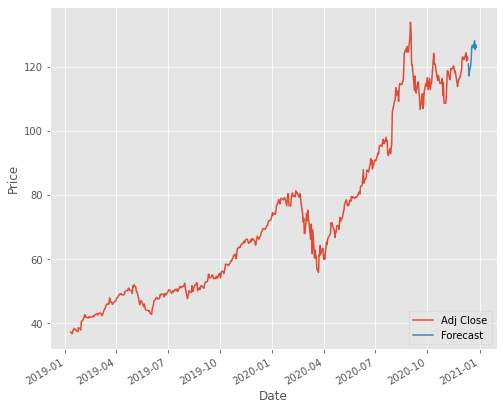

In [74]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()